In [1]:
import datacube 
import matplotlib.pyplot as plt
import pandas as pd
import pytz
import numpy as np
import xarray as xr

from scipy.stats import cumfreq
from otps import TimePoint, predict_tide
# from otps import predict_tide
from dea_tools.dask import create_local_dask_cluster

import sys
sys.path.append("../Tools/dea_tools")
from coastal_temp import (select_aoi, 
                          exp_model, 
                          prep_aoi, 
                          plot_summary)


In [2]:
dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38005 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/dev_intexp/dea-notebooks/Real_world_examples/dask-worker-space/worker-l0khkjj6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/dev_intexp/dea-notebooks/Real_world_examples/dask-worker-space/worker-xd6ampyf', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/38005/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/38005/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42683,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/38005/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:34129,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/39705/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:41761,


In [3]:
m, master_gdf, roi = select_aoi()
display (m)

Map(center=[-32.13054578933222, 136.10234378608968], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [4]:
## Following selection of your area of interest using the shape options in the map menu
## and your tide-modelling position, using the `marker` option, run this cell to
## prepare the selections for analysis. Note that this is a per-pixel analysis. Consequently,
## a small area of interest is advised to minimise computation time.

tp, working_gdf, geom = prep_aoi(roi, master_gdf)

In [154]:
tp

[122.177582, -18.036178]

In [6]:
## Set the user-defined variables 

## Define the tidal-modelling period start and end dates. This is the period over which intertidal
## exposure will be calculated. Ideally, this period should be an 18.6 year window to account
## for the full average range of astronomical forcings on the tide (e.g. Haigh et al., 2011).
## However, a shorter window is advised in this application to minimise the computation time.
## Note that if a filter is applied to the tide-model, e.g. restricted date or tide range, then
## a wide tidal-modelling period may be achievable on this platform.

## Tidal modelling period. Format: 'YYYY-MM-DD HH:MM:SS'
time_start = '1985-12-01 00:00:00'
time_end = '2023-01-01 00:00:00'

## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq='30min'

# ## Set the filter to apply for the exposure modelling. Options:
'''
    'all_time',
    'daynight',
    'springneap',
    'wet',
    'dry',
    'summer',
    'autumn',
    'winter',
    'spring',
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
'''
time_filter = ['all_time']

query = {
    'product': ['nidem'],
    "dask_chunks": {"time": 1, "x": 100000, "y": 100000},
    "geopolygon": geom
        }

In [155]:
ds = dc.load(**query)
ds2 = ds.where(ds.nidem > ds.nidem.min())
ds2 = ds2.compute()

In [10]:
def exp_model(time_start, 
              time_end, 
              time_filter, 
              modelled_freq, 
              tidepost_lat, 
              tidepost_lon, 
              ds):      
    ## Run tidal modelling

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]
        ## Save modelled tides as dataframe
        ## Firstly convert the dates to series
    all_timerange = all_timerange.to_series()
        ## Save dates and tideheights to pd.DataFrame
    modelledtides = pd.DataFrame(data={'timerange': all_timerange,
                       'tideheights': all_tideheights})
    
    print ('Complete: Tidal modelling. Starting: Local timezone conversion')

    '''---------------------------------------------------------'''
    ## Automate timezone selection based on location of tidepost
    ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
    if tidepost_lon <= 129.0:
        timezone = 'Australia/West'
        local_tz = 8
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/North'
        local_tz = 9.5
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
        timezone = 'Australia/South'
        local_tz = 9.5
    elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/Queensland'
        local_tz = 10
    elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
        timezone = 'Australia/NSW'
        local_tz = 10
    else:
        print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
    print('Timezone set to', timezone)
    
    ## Convert time_start and time_end to datetime objects in local timezone
    time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
    time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
    ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
    localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

    ## Convert tz-aware index to local timezone
    localtides = localtides.tz_convert(timezone)
    
    ## Reset the index of modelledtides to reflect local times
    modelledtides['local_timerange'] = localtides
    modelledtides.set_index('local_timerange', inplace=True)
    modelledtides.drop('timerange', axis=1, inplace=True)
    
#     '''
#     Solar modelling section
#     '''
    
#         ## Create all required time filters
#     ## Create dict to store filtered times
#     filters = {}
    
#     ## Create a filteredtides dataframe for the filters of interest
#     for x in time_filter:
        
#         if x == 'all_time':
#             filteredtides = modelledtides
#             filters[str(x)] = filteredtides
#     '''
#     All the other filters go here
#     '''
#         else:
#             print('''
#             Please select one of the following `time_filter`s: 
#             all_time, day, night, springneap, wet, dry, summer, autumn, winter, 
#             spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, 'wet_springneap'
#             ''')
    
#         print ('Complete: datetime filtering. Starting: wet/dry masking')
    
#     ## Create wet/dry boolean for each timestep per filter
#     WetDry = {}
#     for key in filters:
                
#         ## Boolean mask all modelled timesteps by tideheight relative to NIDEM:
#         da_list = list(ds.nidem >= filters[str(key)]['tideheights'][timestep] 
#                        for timestep in filters[str(key)].loc[time_start:time_end].index) 

#         index_list = list(timestep for timestep in filters[str(key)][time_start:time_end].index)

#         ## Store modelled datetimes as a pandas index
#         index = pd.Index(index_list, name='datetime')

#         ## Concatenate the arrays on the new dimension 'datetime'
#         exp_ds = xr.concat(da_list, index)
        
#         WetDry[str(key)] = exp_ds
        
#     print ('Complete: wet/dry masking. Starting: exposure calculations')
    
#     '''--------------------------------------------'''
#     ## Calculate the pc exposure per pixel for each filter
#     ## Build empty xr.ds and append each new da during looping through WetDry
    
#     pxpc2 = ds#.squeeze().reset_coords() ## Copy of NIDEM ds to append exposure results into
    
#     for f in WetDry:
    
#             ## Calculate the mean of the boolean across the datetime axis (equiv. to % True)
#         pxpc = WetDry[str(f)].mean('datetime')

# #         # Compute the array from dask
# #         pxpc = pxpc.compute() #%timeit

#         ## Name the exposure time array
#         pxpc = pxpc.rename('Exposure time (%)')

#         ## Mask out non-intertidal areas
#         pxpc = pxpc.where(pxpc > 0) ############################TEMP masked to capture 0% fraction 22/07/2022. Add back in for regular exposure modelling. CP
        
#         ## Append filter (f) exposure results into results dataset (pxpc2)
#         pxpc2[str(f)] = pxpc#.drop('time')

#     print('Complete: exposure calculations. Starting: ds.compute')
#     pxpc2 = pxpc2.compute()    
#     print ('Complete: ds.compute')

    return modelledtides#, filters, pxpc2

In [11]:
modelledtides_neg_lat = exp_model(time_start,
                                  time_end,
                                  time_filter,
                                  modelled_freq,
                                  tidepost_lat = tp[1],# = -17.420604,
                                  tidepost_lon = tp[0],# = 140.665169,
                                  ds=ds2)

Complete: Tidal modelling. Starting: Local timezone conversion
Timezone set to Australia/West


In [163]:
## After https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cumfreq.html

## Extract modelled tideheights as np.array
modelledtides = (np.array(modelledtides_neg_lat.tideheights))

## Calculate number of bins to use in cumulative frequency calculation, ensuring continentally consistent bin size of 0.05m (arbitrary bin size)
binsize = 0.05
bins = (modelledtides_neg_lat.tideheights.max() - modelledtides_neg_lat.tideheights.min())/binsize

## Calculate cumulative frequencies
res = cumfreq(modelledtides, numbins=int(bins)) #1000)

# Calculate space of values for x
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size, res.cumcount.size)

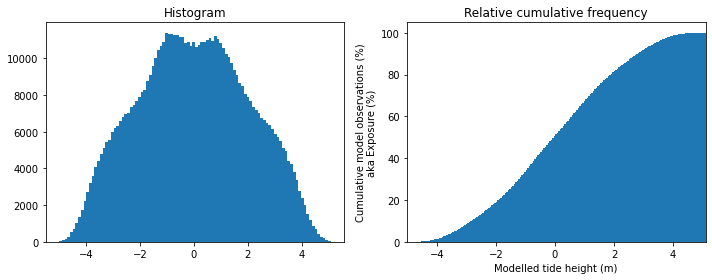

In [164]:


fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(modelledtides, bins=100)
ax1.set_title('Histogram')
ax2.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)
ax2.set_title('Relative cumulative frequency')
ax2.set_ylabel('Cumulative model observations (%)\naka Exposure (%)')
ax2.set_xlabel('Modelled tide height (m)')
ax2.set_xlim([x.min(), x.max()])
fig.tight_layout()

In [165]:
## Save the relative cumulative frequency dataset as an array to act as a lookup table for the NIDEM heights
testdict={'tideheight_max': x, 'cumfreq': res.cumcount/len(modelledtides)*100}
test = pd.DataFrame(data=testdict)

## tideheight_min and tideheight_max represent the binned range of tide heights modelled to the associated cumulative frequency (exposure %)
shifted = test.tideheight_max.shift(periods=1)
updatedvalue = test.tideheight_max[0] - binsize
shifted.update(pd.Series([updatedvalue], index=[0]))

test['tideheight_min']=shifted

print(test)

     tideheight_max     cumfreq  tideheight_min
0         -5.016170    0.000308       -5.066170
1         -4.965578    0.001692       -5.016170
2         -4.914987    0.004768       -4.965578
3         -4.864395    0.011689       -4.914987
4         -4.813803    0.020456       -4.864395
..              ...         ...             ...
196        4.899803   99.985234        4.849212
197        4.950395   99.991694        4.899803
198        5.000987   99.996616        4.950395
199        5.051578   99.999231        5.000987
200        5.102170  100.000000        5.051578

[201 rows x 3 columns]


In [17]:
from tqdm import tqdm ## Show a smart progress meter for loops

In [ ]:
# ## Slow loop through both dataframes assessing exposure values for every nidem pixel

# ## Iterrows method (slow)
# %time
# nidem_df['Exposure'] = pd.Series(dtype='float64')

# for i, d in tqdm(nidem_df[0:10].iterrows()):
    
#     for ii, dd in test.iterrows():
        
#         if (d.nidem >= dd.tideheight_min) & (d.nidem < dd.tideheight_max):
            
#             nidem_df.Exposure.update(pd.Series([dd.cumfreq], index=[i]))


In [166]:
## Duplicate the NIDEM DataArray to replace with Exposure values
Exp = ds2.nidem.copy(deep=True)
Exp = Exp.rename('Exposure')

%time
for x in tqdm(range(0,len(ds2.x))):
    for y in range(0,len(ds2.y)):
        d = ds2.isel(x=x, y=y)
        v = d['nidem'].values[0]
        if str(v) == 'nan':
            continue
        else:

            ## the largest element of tideheight_min that is less than `v`
            small = test.tideheight_min[test.tideheight_min <= v].max()

            ## the smallest element of tideheight_max that is greater than `v`
            large = test.tideheight_max[test.tideheight_max > v].min()

            ## find the associated cumulative frequence (exposure) with `small` and `large`
            cf = test.loc[(test.tideheight_min==small) & (test.tideheight_max==large)]

#             ds2.isel(x=x, y=y)['Exposure'] = cf.cumfreq
            Exp.isel(x=x, y=y).values[0] = cf.cumfreq
    
## Add the exposure array to the nidem DataSet
ds2['Exposure'] = Exp

######################## ToDo: Try and replicate this loop directly on the xr.DataSet using xr.apply_ufunc  #############################

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


100%|██████████| 1247/1247 [09:34<00:00,  2.17it/s]


<bound method Figure.tight_layout of <Figure size 1440x576 with 4 Axes>>

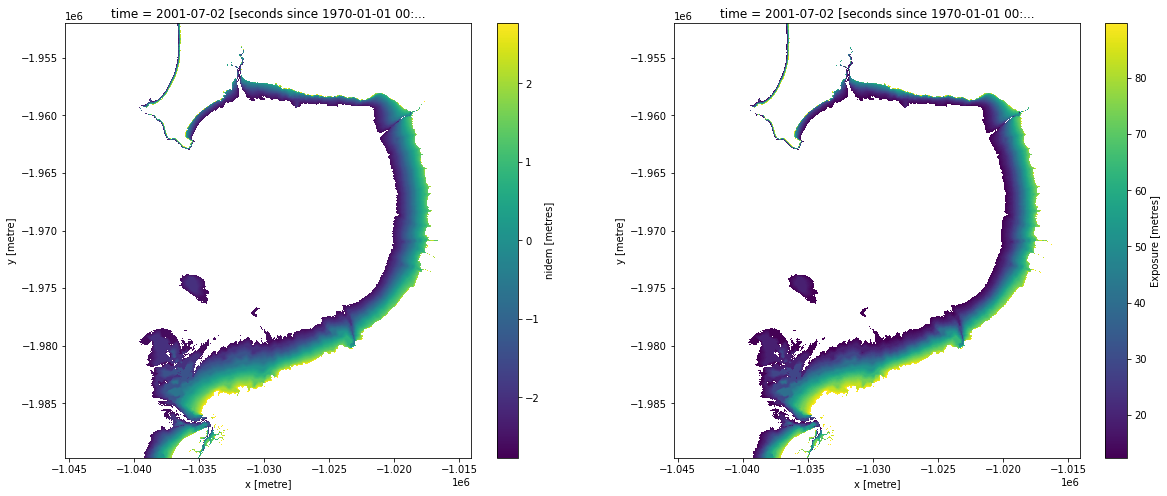

In [167]:
plt.close()

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ds2.nidem.plot(ax=ax1, cmap='viridis')
ds2.Exposure.plot(ax=ax2, cmap='viridis')
# ax1.plot(ds2.nidem.isel(time=0))
# ax2.plot(ds2.Exposure.isel(time=0))
fig.tight_layout


# ax1.hist(modelledtides, bins=100)
# ax1.set_title('Histogram')
# ax2.bar(x, res.cumcount/len(modelledtides)*100, width=res.binsize)
# ax2.set_title('Relative cumulative frequency')
# ax2.set_ylabel('Cumulative model observations (%)\naka Exposure (%)')
# ax2.set_xlabel('Modelled tide height (m)')
# ax2.set_xlim([x.min(), x.max()])
# fig.tight_layout()

In [149]:
from datacube.utils.cog import write_cog

In [168]:
# Select a single time-slice
rgb_da = ds2.nidem.isel(time=0)#.to_array()

# Write multi-band GeoTIFF to a location
write_cog(geo_im=rgb_da,
          fname='binsize_'+str(binsize)+'_nidem_rgb.tif',
          overwrite=True)

PosixPath('binsize_0.05_nidem_rgb.tif')

In [169]:
# Select a single time-slice
rgb_da = ds2.Exposure.isel(time=0)#.to_array()

# Write multi-band GeoTIFF to a location
write_cog(geo_im=rgb_da,
          fname='binsize_'+str(binsize)+'_exposure_rgb.tif',
          overwrite=True)

PosixPath('binsize_0.05_exposure_rgb.tif')

In [133]:
# ## Attempt a solution using xr.apply_ufunc

# def Exp_calc(ds2.isel(time=0), ds2.x, ds2.y, test):
#     for y in ds2.nidem.x:
#         d = ds2.isel(x=x, y=y)
#         v = d['nidem'].values[0]
#         if str(v) == 'nan':
#             continue
#         else:

#             ## the largest element of tideheight_min that is less than `v`
#             small = test.tideheight_min[test.tideheight_min <= v].max()

#             ## the smallest element of tideheight_max that is greater than `v`
#             large = test.tideheight_max[test.tideheight_max > v].min()

#             ## find the associated cumulative frequence (exposure) with `small` and `large`
#             cf = test.loc[(test.tideheight_min==small) & (test.tideheight_max==large)]

# #             ds2.isel(x=x, y=y)['Exposure'] = cf.cumfreq
# #             Exp.isel(x=x, y=y) = cf.cumfreq
#             return cf.cumfreq


